# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Alrbright, Gavin Fry

In [51]:
# Start with all of the includes we'll need for the project...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
# Begin...

In [ ]:
df = pd.read_csv("reviews.csv")

In [ ]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [ ]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

In [69]:
# Clustering
df.head()

,steamid,appid,is_recommended,upvotes,votes_funny,helpful_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,PC1,PC2
0,76561198795470246,599080,True,1,0,0.52381,400,400,230,2,Minus the quiet communication (other players s...,-2306.205,-0.185831
1,76561199026616351,599080,True,0,0,0.00000,745,192,19,8,yeah.,-771.205,-0.185077
2,76561198259829110,599080,True,0,0,0.00000,1572,1572,50,4,Playing this game was the most fun I have ever...,-1864.205,0.338196
3,76561198123742442,599080,True,0,0,0.00000,3684,2001,119,1,I love the interactive lore and story telling,1361.795,-0.184031
4,76561198998908891,599080,True,0,0,0.00000,249,249,31,10,gg,-2257.205,0.338003


C:\Users\knght\AppData\Local\Temp/ipykernel_1724/2022193170.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'PC2_x', 'PC1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, pca_df, right_index=True, left_index=True)


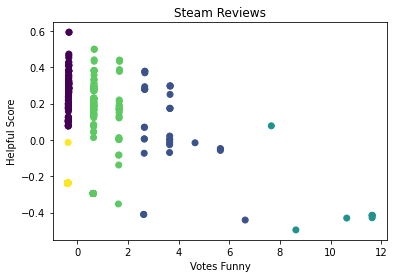

In [77]:
df2 = df[["votes_funny", "helpful_score"]]
data = df2.sample(n=1000, replace = True)

# Define number of clusters
num_clusters = 5
 
pca = PCA()
data_pca = pca.fit_transform(data)

pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])
df = pd.merge(df, pca_df, right_index=True, left_index=True)
    
# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(data)
 
# Predict the target variable
pred=km.predict(data)

# Plot the Clusters
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred)
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()